In [1]:
import firedrake
from firedrake import exp, sin, cos, max_value, Constant, interpolate, dx, sqrt, inner, as_vector
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import icepack
import icepack.plot
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m
)
import os
import numpy as np
import tqdm
import random
from math import floor
from collections import deque
from scipy.interpolate import RegularGridInterpolator

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


# Grounded ice-stream (experiment 2)
We start by defining the domain geometry and the function spaces over which we will be solving the equations of state for ice thickness and ice velocity. We'll use plug flow assumptions (shelfy-stream equations) to bootstrap solutions that represent vertical shear using the hyrbrid ice-flow model (1st order approximation to the stockes equations). This will solve equations on a 2D footprint mesh that we can then interpolate onto a vertically extruded interval mesh. We'll start by defining the geometry (domain boundaries and basal topogarphy) as well as the perscribed friction coefficient field that we will use in the ice sheet model simulations.


In [2]:
Lx,Ly = 640e3,80e3
ny=25
nx=int(Lx/Ly) * ny
area = Lx*Ly
A = Constant(20)
coarse_mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
mesh_hierarchy = firedrake.MeshHierarchy(coarse_mesh, 2)
mesh2d = mesh_hierarchy[1]
Q2 = firedrake.FunctionSpace(mesh2d, family='CG', degree=2)
V2 = firedrake.VectorFunctionSpace(mesh2d, family='CG', degree=2)

mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

Q3 = firedrake.FunctionSpace(mesh, 'CG', 2, vfamily='R', vdegree=0)

V3_0 = firedrake.VectorFunctionSpace(
    mesh, 'CG', 2, vfamily='R', vdegree=0, dim=2
)

V3_2 = firedrake.VectorFunctionSpace(
    mesh, 'CG', 2, vfamily='GL', vdegree=2, dim=2
)

x, y, ζ = firedrake.SpatialCoordinate(mesh)

# Bed topography
We define the base topography using equations for the mismip+ exxperiment that we perturb using a random mid-point displacement algorthim.

In [3]:
def mismip_bed(Q):
    mesh=Q.mesh()
    x, y = firedrake.SpatialCoordinate(mesh)

    x_c = Constant(300e3)
    X = x / x_c

    B_0 = -150
    B_2 = -728.8
    B_4 = 343.91
    B_6 = -50.57
    B_x = B_0 + B_2 * X**2 + B_4 * X**4 + B_6 * X**6

    f_c = 4e3
    d_c = 500
    w_c = 24e3
    B_y = d_c * (
        1 / (1 + exp(-2 * (y - Ly / 2 - w_c) / f_c)) +
        1 / (1 + exp(+2 * (y - Ly / 2 + w_c) / f_c))
    )
    
    z_deep = -720
    z_b = interpolate(max_value(B_x + B_y, z_deep), Q)
    
    return max_value(B_x + B_y, z_deep)

In [4]:
def perturb_bed(Q,Nx=nx,Ny=ny,mu=0,sigma=200,method='linear'):
    mesh = Q.mesh()
    element = Q.ufl_element()
    V = firedrake.VectorFunctionSpace(mesh, element)
    X = firedrake.interpolate(mesh.coordinates, V2).dat.data_ro
    bed_perturb = firedrake.Function(Q)
    
    size = max(Nx,Ny)
    x=np.linspace(X[:, 0].min(),X[:, 0].max(),size)
    y=np.linspace(X[:, 1].min(),X[:, 1].max(),size)


    perturb=np.zeros((size,size))
    perturb[0][0]=random.randint(0, 0)
    perturb[size-1][0]=random.randint(0, 0)
    perturb[0][size-1]=random.randint(0, 0)
    perturb[size-1][size-1]=random.randint(0, 0)
    
    q = deque()
    q.append((0,0,size-1,size-1,sigma))
    
    while len(q) != 0:
        top, left, bottom, right, randomness = q.popleft()
        centerX = (left + right) // 2
        centerY = (top + bottom) // 2
        
        perturb[centerX][top] = (perturb[left][top] + perturb[right][top]) // 2 + random.randint(-randomness, randomness)
        perturb[centerX][bottom] = (perturb[left][bottom] + perturb[right][bottom]) // 2 + random.randint(-randomness, randomness)
        perturb[left][centerY] = (perturb[left][top] + perturb[left][bottom]) // 2 + random.randint(-randomness, randomness)
        perturb[right][centerY] = (perturb[right][top] + perturb[right][bottom]) // 2 + random.randint(-randomness, randomness)        
        
        perturb[centerX][centerY] = (perturb[left][top] +
                                       perturb[right][top] +
                                       perturb[left][bottom] +
                                       perturb[right][bottom]) // 4 + \
                                      random.randint(-randomness, randomness)

        if right - left > 2:
            q.append((top, left, centerY, centerX, randomness // 2))
            q.append((top, centerX, centerY, right, randomness // 2))
            q.append((centerY, left, bottom, centerX, randomness // 2))
            q.append((centerY, centerX, bottom, right, randomness // 2))

    interpolator = RegularGridInterpolator((x, y), perturb, method=method)
    bed_perturb.dat.data[:] = interpolator(X, method)
    return bed_perturb

In [5]:
def friction_perturb(mesh,n=30,dx=5500,dy=5500):
    

    M=np.random.rand(n,3)
    M[:,0]=(M[:,0])*Lx
    M[:,1]=(M[:,1])*Ly
    M[:,2]=M[:,2]*1e-2
    x,y  = firedrake.SpatialCoordinate(mesh)
    C= Constant(0.0)
    for i in range(n):
        C=C+M[i,2]*exp(-(x-Constant(M[i,0]))**2/dx**2-(y-Constant(M[i,1]))**2/dy**2)
    return C+Constant(5e-3)-x**(1/3)*Constant(5e-3)/Lx**(1/3)
    

In [6]:
if not os.path.exists('friction.h5'):
    C=interpolate(friction_perturb(mesh2d),Q2)
    
    with firedrake.DumbCheckpoint(
        'friction', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(C, name='friction')

else:
    C = firedrake.Function(Q2)
    
    with firedrake.DumbCheckpoint(
        'friction', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(C, name='friction')

In [7]:
z_b = interpolate(mismip_bed(Q2), Q2)
z_perturb = perturb_bed(Q2,Nx=nx,Ny=ny,mu=0,sigma=200,method='linear')

In [8]:
bed = interpolate(z_perturb+z_b,Q2) 

In [ ]:
if not os.path.exists('bed.h5'):
    C=interpolate(friction_perturb(mesh2d),Q2)
    
    with firedrake.DumbCheckpoint(
        'bed', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(bed, name='bed')

else:
    C = firedrake.Function(Q2)
    
    with firedrake.DumbCheckpoint(
        'bed', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(bed, name='bed')

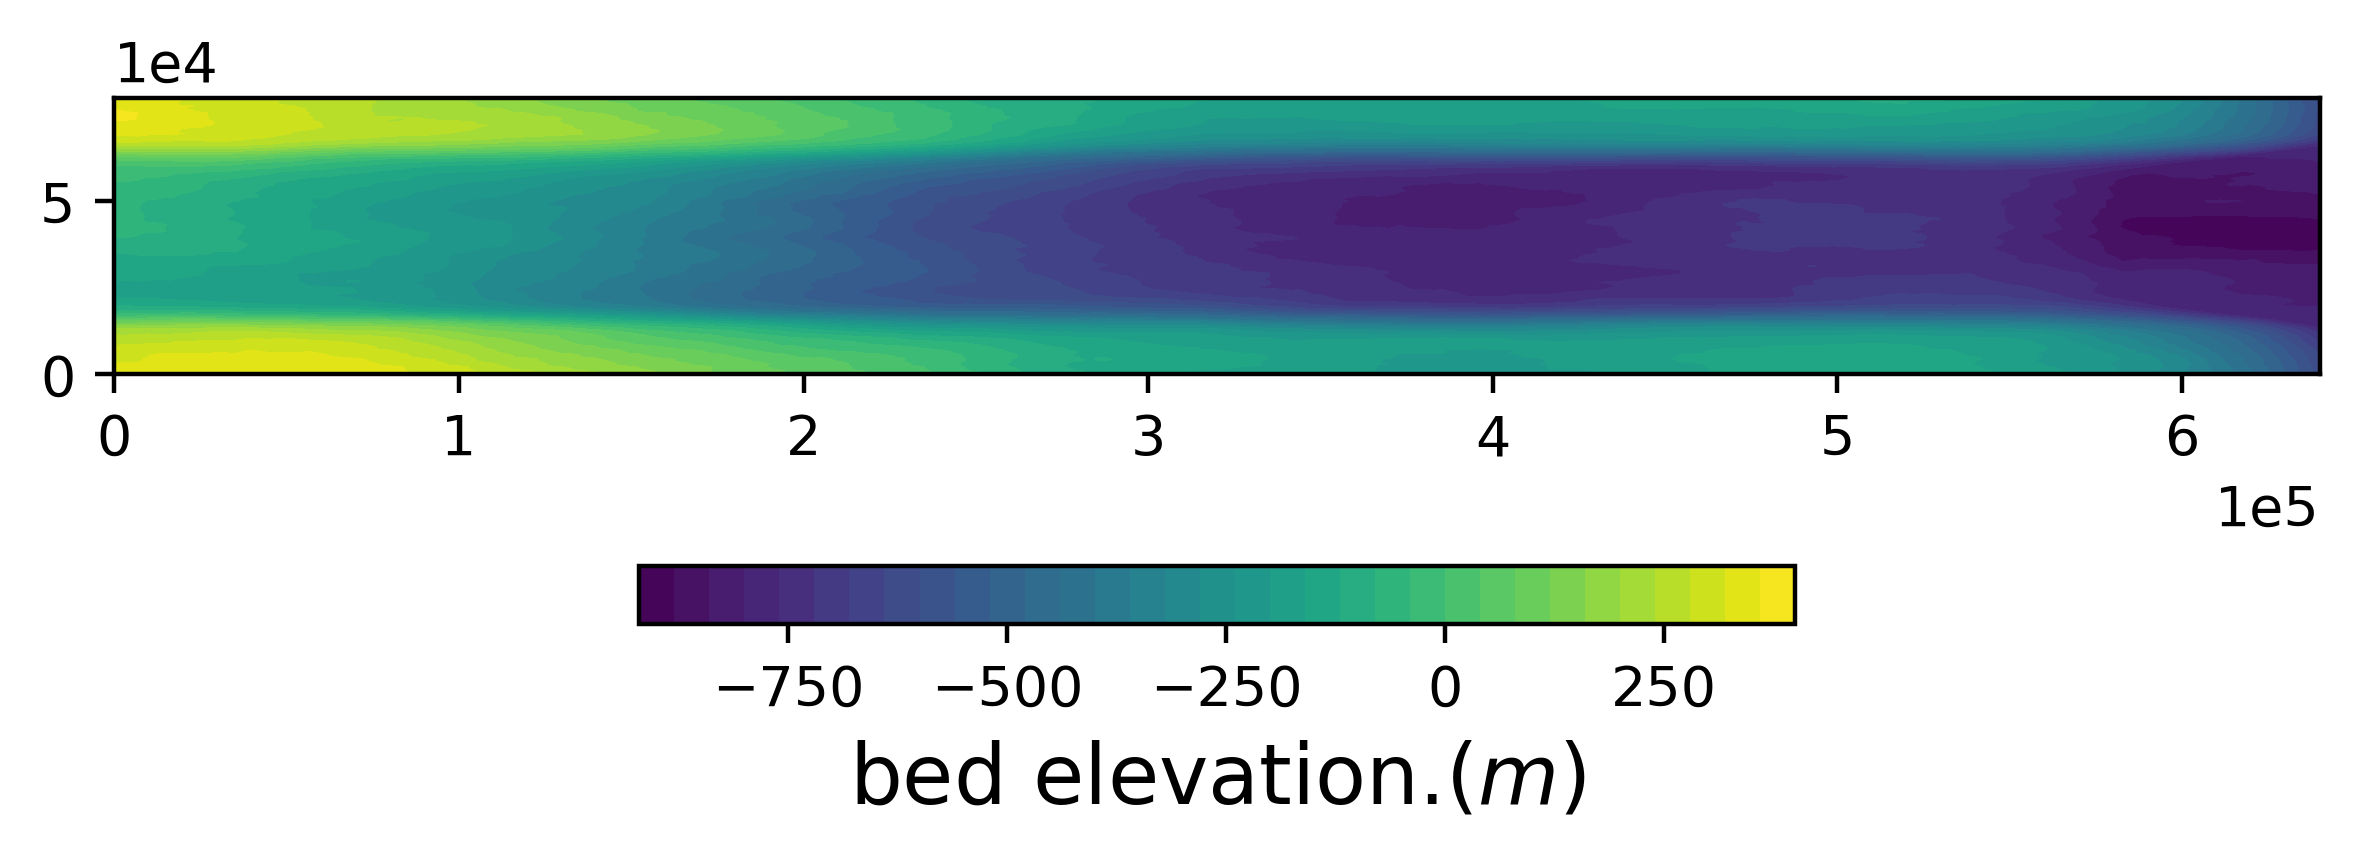

<Figure size 432x288 with 0 Axes>

In [10]:
fig, axes = icepack.plot.subplots(dpi=400)
contours = icepack.plot.tricontourf(bed, 40, axes=axes)
CS=plt.colorbar(contours, ax=axes, orientation='horizontal', pad=0.15,fraction=.045,ticks=[-1000,-750,-500,-250,0,250,500])
CS.set_label(r'bed elevation.($m$)',fontsize=15)
plt.tight_layout()
plt.show(fig)
plt.savefig('figures/fig01/bed.png')

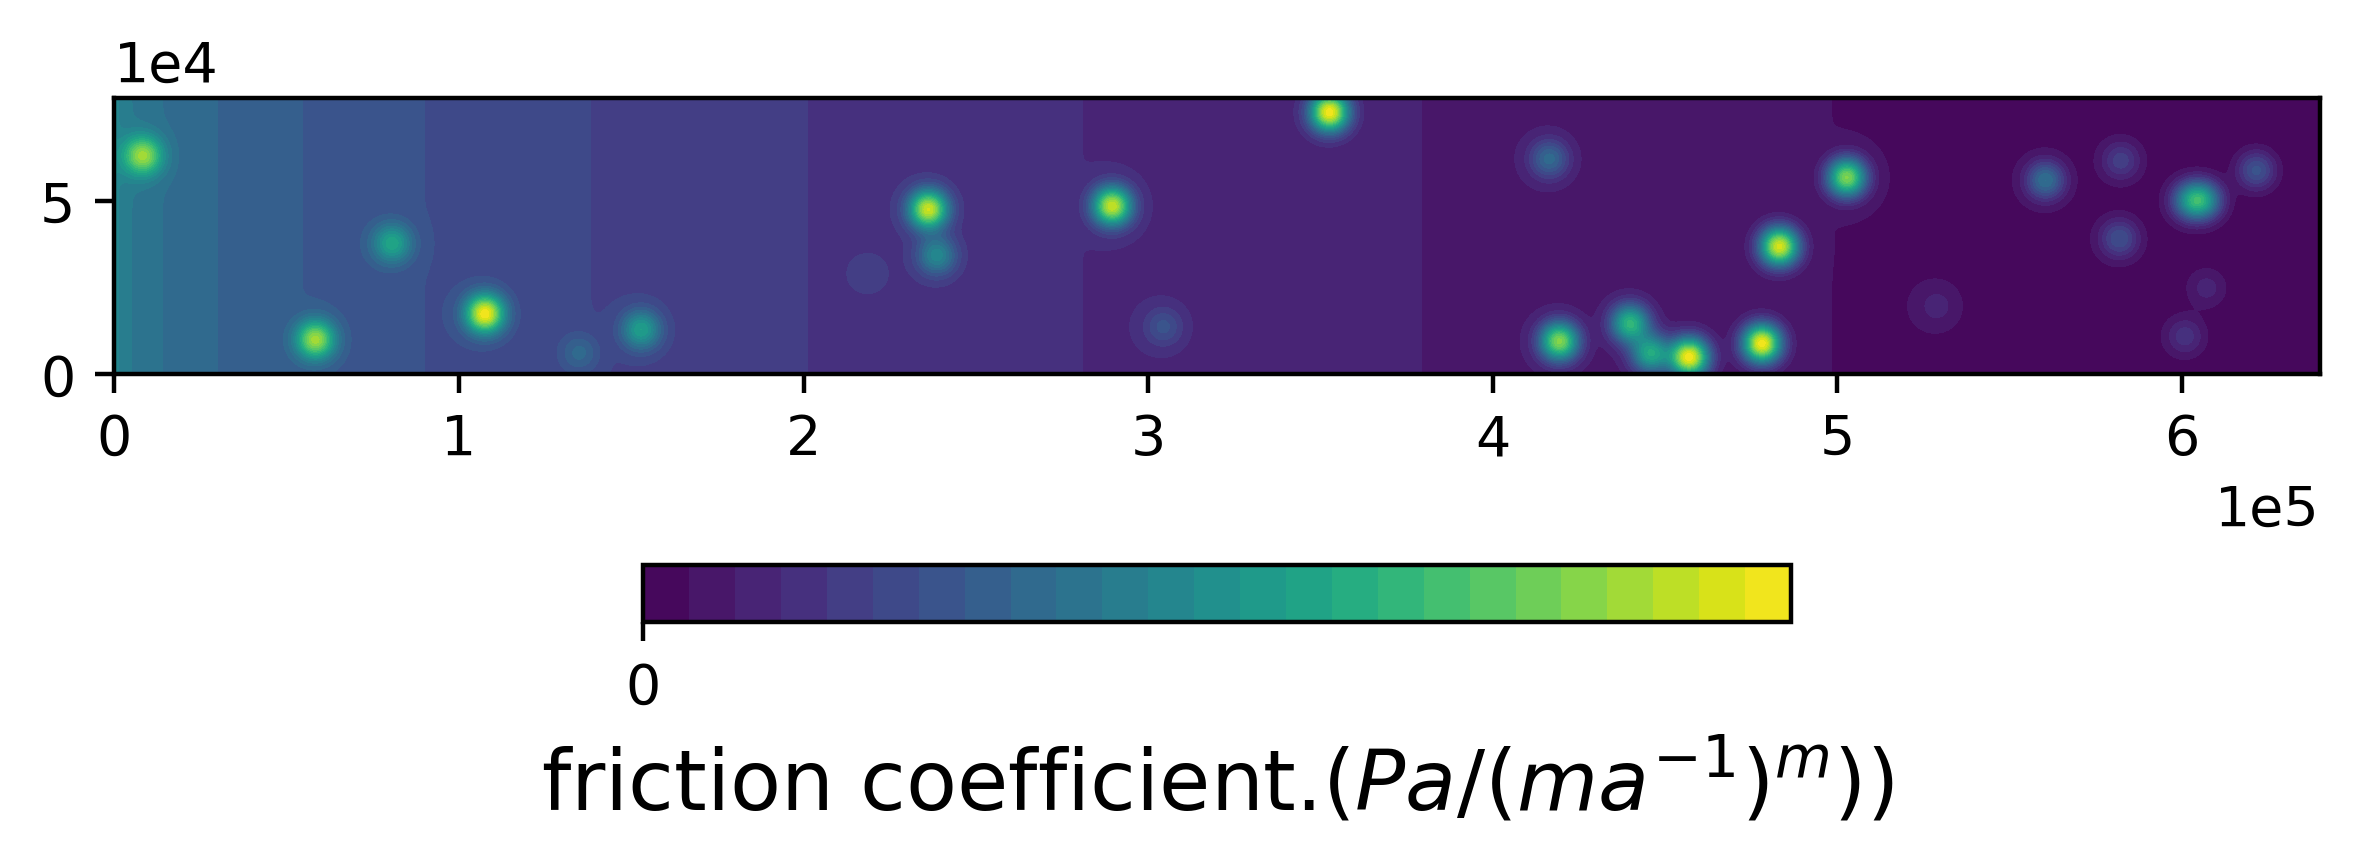

<Figure size 432x288 with 0 Axes>

In [11]:
fig, axes = icepack.plot.subplots(dpi=400)
contours = icepack.plot.tricontourf(C, 25, axes=axes)
CS=plt.colorbar(contours, ax=axes, orientation='horizontal', pad=0.15,fraction=.045,ticks=[-1000,-750,-500,-250,0,250,500])
CS.set_label(r'friction coefficient.($Pa/(ma^{-1})^{m})$)',fontsize=15)
plt.tight_layout()
plt.show(fig)
plt.savefig('figures/fig02/friction.png')

In [12]:
def friction(**kwargs):
    variables = ('velocity', 'thickness', 'surface', 'friction')
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C)**m
    u_b = sqrt(inner(u, u))

    return τ_c * (
        (u_c**(1/m + 1) + u_b**(1/m + 1))**(m / (m + 1)) - u_c
    )

In [13]:
a = Constant(0.3)

In [14]:
model = icepack.models.IceStream(friction=friction)

In [15]:
h_0 = icepack.interpolate(Constant(100), Q2)
s_0 = icepack.compute_surface(thickness=h_0, bed=bed)

In [ ]:
from firedrake import as_vector
opts = {
    'dirichlet_ids': [1],
    'side_wall_ids': [3, 4],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'snes_type': 'newtontr',
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
solver = icepack.solvers.FlowSolver(model, **opts)

x,y= firedrake.SpatialCoordinate(mesh2d)
u_0 = solver.diagnostic_solve(
    velocity=interpolate(as_vector((90 * x / Lx, 0)), V2),
    thickness=h_0,
    surface=s_0,
    fluidity=A,
    friction=C
)


# Run simulation
We start by defining a function that can update the thickness surface height and the velocity at each iterate of the model.

In [ ]:
area = firedrake.assemble(Constant(1) * dx(mesh2d))

def run_simulation(solver,C, h, s, u, time, dt):
    num_steps = int(final_time / dt)
    progress_bar = tqdm.trange(num_steps)
    for step in progress_bar:
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_0
        )
        s = icepack.compute_surface(thickness=h, bed=bed)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C
        )

        min_h = h.dat.data_ro.min()
        avg_h = firedrake.assemble(h * dx) / area
        description = f"avg, min h: {avg_h:4.2f}, {min_h:4.2f}"
        progress_bar.set_description(description)
        
    return h, s, u

In [18]:
import os
final_time = 2000
dt = 3.

if not os.path.exists('mismip-degree1.h5'):
    h, s, u = run_simulation(
        solver,C, h_0, s_0, u_0, final_time, dt
    )
    
    with firedrake.DumbCheckpoint(
        'mismip-degree1', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(h, name='thickness')
        checkpoint.store(s, name='surface')
        checkpoint.store(u, name='velocity')

else:
    h = firedrake.Function(Q2)
    s = firedrake.Function(Q2)
    u = firedrake.Function(V2)
    
    with firedrake.DumbCheckpoint(
        'mismip-degree1', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(h, name='thickness')
        checkpoint.load(s, name='surface')
        checkpoint.load(u, name='velocity')

avg, min h: 453.62, 91.59: 100%|████████████| 666/666 [6:23:23<00:00, 34.54s/it]


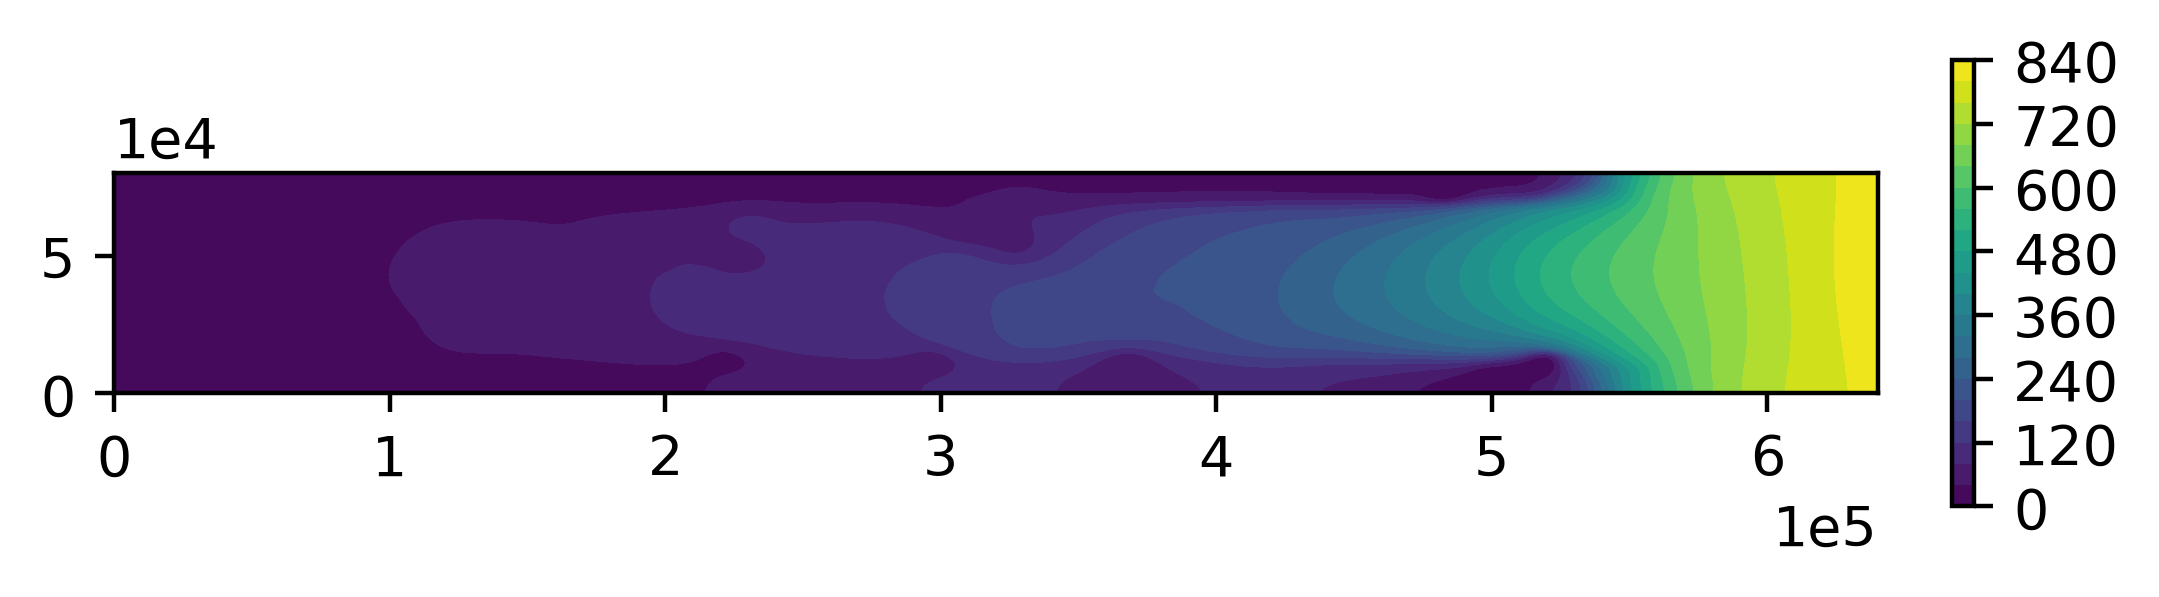

In [127]:
fig, axes = icepack.plot.subplots(dpi=400)
contours = icepack.plot.tricontourf(u, 25, axes=axes)
CS=plt.colorbar(contours, ax=axes, orientation='horizontal', pad=0.15,fraction=.045,ticks=[0,250,500,750,1000])
CS.set_label(r'velocity.($ma^{-1}$)',fontsize=15)
plt.tight_layout()
plt.show(fig)
plt.savefig('figures/fig03/velocity.png')

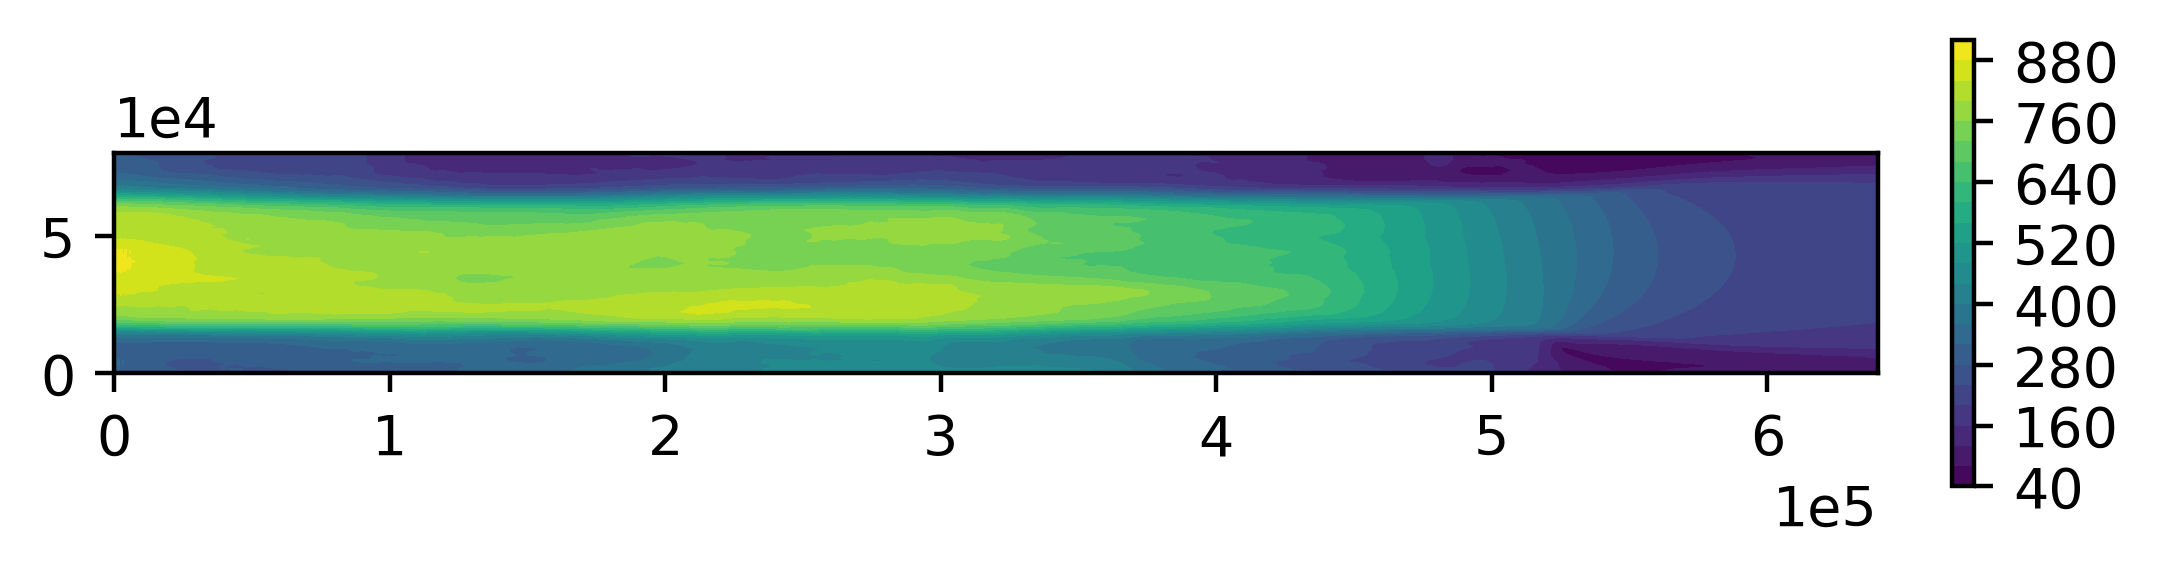

In [146]:
fig, axes = icepack.plot.subplots(dpi=400)
contours = icepack.plot.tricontourf(h, 25, axes=axes)
CS=plt.colorbar(contours, ax=axes, orientation='horizontal', pad=0.15,fraction=.045,ticks=[0,250,500,750,1000])
CS.set_label(r'thickness.($m$)',fontsize=15)
plt.tight_layout()
plt.show(fig)
plt.savefig('figures/fig04/thickness.png')

In [53]:
from firedrake import ds
ν = firedrake.FacetNormal(mesh2d)
flux = h * inner(u, ν) * ds(2)

UFL:ERROR Found domains with different geometric dimensions.


UFLException: Found domains with different geometric dimensions.

In [54]:
print(f'Flux: {firedrake.assemble(flux) / 1e9} km^3 / year')

NameError: name 'flux' is not defined

In [141]:
influx = -h * inner(u, ν) * ds(1)
print(f'Influx: {firedrake.assemble(influx) / 1e9} km^3 / year')

Influx: 0.0 km^3 / year


# Bootstrapping to higher order solution
Next we'll use the solution we derived from the SSA equations to determine the solution for the higher order model.

In [48]:
Qc = firedrake.FunctionSpace(
    mesh, family='CG', degree=2, vfamily='R', vdegree=0
)


Vc = firedrake.VectorFunctionSpace(
    mesh, dim=2, family='CG', degree=2, vfamily='R', vdegree=0
)

C= icepack.lift3d(C, Qc)
s=icepack.lift3d(s,Qc)
h = icepack.lift3d(h, Qc)
h_0 = icepack.lift3d(h_0, Qc)
bed = icepack.lift3d(bed,Qc)
u0 = icepack.lift3d(u,Vc)

In [49]:
V4 = firedrake.VectorFunctionSpace(
    mesh, dim=2, family='CG', degree=2, vfamily='GLL', vdegree=4
)



x, y, ζ = firedrake.SpatialCoordinate(mesh)
u_initial = firedrake.interpolate((1 - 0.5 * (1 - ζ)**2) * u, V4)
u=firedrake.interpolate(u_initial,V4)


In [50]:
def friction(**kwargs):
    variables = ('velocity', 'thickness', 'surface', 'friction')
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C)**m
    u_b = sqrt(inner(u, u))
    return τ_c * (
        (u_c**(1/m + 1) + u_b**(1/m + 1))**(m / (m + 1)) - u_c
    )

flow_model = icepack.models.HybridModel(friction=friction)



In [51]:
opts = {
    'dirichlet_ids': [1],
    'side_wall_ids': [3, 4],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'snes_type': 'newtontr',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

In [52]:
final_time = 5000
dt = 2.
h, s, u = run_simulation(
    flow_solver, C, h, s, u, final_time, dt
)

  0%|                                                  | 0/2500 [00:00<?, ?it/s]tsfc:WARNING Estimated quadrature degree (46, 60) more than tenfold greater than any argument/coefficient degree (max (2, 4))
tsfc:WARNING Estimated quadrature degree (46, 60) more than tenfold greater than any argument/coefficient degree (max (2, 4))
tsfc:WARNING Estimated quadrature degree (74, 100) more than tenfold greater than any argument/coefficient degree (max (2, 4))
tsfc:WARNING Estimated quadrature degree (74, 100) more than tenfold greater than any argument/coefficient degree (max (2, 4))
avg, min h: 453.66, -276.38:   1%|  | 13/2500 [18:05:01<3459:33:24, 5007.80s/it]


ConvergenceError: Nonlinear solve failed to converge after 50 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT

In [ ]:
import icepack.plot
fig, axes = icepack.plot.subplots()
axes.get_yaxis().set_visible(False)
triangles = icepack.plot.tripcolor(
    firedrake.interpolate(u_0-u,V2), vmin=-50, vmax=50, shading='gouraud', axes=axes
)
fig.colorbar(triangles, fraction=0.01, pad=0.046);

In [ ]:
import icepack.plot
fig, axes = icepack.plot.subplots()
axes.get_yaxis().set_visible(False)
triangles = icepack.plot.tripcolor(
    firedrake.interpolate(h_0-h,Q2), vmin=-5, vmax=5, shading='gouraud', axes=axes
)
fig.colorbar(triangles, fraction=0.01, pad=0.046);

In [ ]:
with firedrake.DumbCheckpoint(
        'mismip-degree2', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(h, name='thickness')
        checkpoint.store(s, name='surface')
        checkpoint.store(u, name='velocity')

In [ ]:
area = firedrake.assemble(firedrake.Constant(1) * dx(mesh))
print(firedrake.assemble(C * dx) / area)

In [ ]:
with firedrake.DumbCheckpoint(
        'bed', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(bed, name='bed')